In [43]:
import pandas as pd
from pymongo import MongoClient
import networkx as nx
import matplotlib.pyplot as plt

# Connect to db collections
client = MongoClient('mongodb://localhost:27017/')
db = client['address-clustering']
transfers = db['transfers']
transactions = db['transactions']

token_transfers = pd.read_csv('../data/token_transfers.csv', index_col=[0])
token_transfers

,timeStamp,hash,from,to,contractAddress,value,nonce,tokenName,gasPrice,gasUsed,chainName,tokenType,tokenID
0,1662353592,0xb40ea5aa7be6a9bd40a401776a5cbcc79baec55abcd3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,NaN,262,Ethereum Name Service,11669714414,35891,Ethereum,721,9.195376e+75
1,1661006285,0x259b903f6c1ec513b9792768859cea2e429aed92375a...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x60ab31673485542e3ca55ba3a42c693863caff10,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,NaN,76,Ethereum Name Service,10898502261,525347,Ethereum,721,2.595492e+76
2,1661687584,0xf028f85d40cb7ad41a95c40f36772e4fcd1c6b5e6bf3...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x8f3cf7ad23cd3cadbd9735aff958023239c6a063,0.11,61,(PoS) Dai Stablecoin,30000068397,32562,Polygon,20,NaN
3,1649007251,0x131db9db1de6204423552c97aedf437776e4c27101b9...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x03ba161f99e0561adc546644640ba6d5602d86c8,0x493a5bad290b6f5a750e180d48074f1de31aec47,NaN,7433,DAZZLE Fashion 2022 MVFW Catwalk,35150000000,271656,Polygon,721,1.300000e+01
4,1652940559,0x4fa9dea1bfef721568d7aa55140b1f7969344a44c0a7...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x0749d1abb5ca9128432b612644c0ea1e9c6cc9af,0xfdac3c4ffccb6e05d3e9a9d69ec95edeb6e8c844,NaN,31220,AO 2022 - Accessories,37064012768,272721,Polygon,721,5.265615e+65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
974473,1671413907,0xff4b2d8133986f6b6a9d6bbd88a2bfb1c5abee3648ea...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0xb854bf4d15be8e1f9b38e8b6af7d3283b81edfd8,NaN,40309,ICE Poker SNG Wearables,61922750388,145726,Polygon,721,2.106246e+65
974474,1671413931,0x0635f1dcc46059bfb00d29130914370cbe4bb2c8061a...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0xbcbdf467b5530d85b792d9e8afb109d7d1ac32c4,NaN,59757,FOMO Bro NFTee,64081415590,137287,Polygon,721,1.620000e+02
974475,1671413955,0xe4dde48b270b76854b461748dfc1c0f5fd0cc986a4ef...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0x873c11f798fc6f6c370c40f460aae4e20069b105,NaN,96970,Roland Lifestyle DCLMVMF 2022,64737010321,162802,Polygon,721,7.320000e+02
974476,1652154158,0x085c04dacb55543e2333f84395b3ae93b8631c69d57f...,0xffffca7879d31e91047d37193a5b806f5f791848,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,0xdac17f958d2ee523a2206206994597c13d831ec7,100.00,27,Tether USD,49354171902,46085,Ethereum,20,NaN


In [44]:
# Get all LAND transfer hashes
LAND_transfers = token_transfers[token_transfers['tokenName']=='Decentraland LAND']
LAND_hashes = LAND_transfers['hash'].to_list()

# Get all token transfers that occured within a LAND transfer
transfers_docs = pd.DataFrame(list(transfers.find({"hash": {"$in": LAND_hashes}})))

transactions_docs = pd.DataFrame(list(transactions.find({"hash": {"$in": LAND_hashes}})))
transactions_docs = transactions_docs[transactions_docs['value']!=0]
transactions_docs['tokenType'] = 'native'

# Drop the '_id' column from the pandas DataFrames
transfers_docs = transfers_docs.drop(['_id', 'isSet', 'userAddress'], axis=1)
transactions_docs = transactions_docs.drop(['_id'], axis=1)

df = pd.concat([transactions_docs, transfers_docs])
df = df.drop_duplicates()
#df = df[['hash', 'from', 'to', 'value','functionName','tokenType','contractAddress', 'tokenName', 'tokenID']]

In [48]:
x = df[df['hash']=='0x165bd2f842319defc83948e54c4ab77631e487ebe82415c272913ab27090a144']
x

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,tokenType,contractAddress,tokenName,tokenID
200,0x165bd2f842319defc83948e54c4ab77631e487ebe824...,0x13936d1369dda5bd295d24bb69dae4e3c6586312,0x00000000000001ad428e4906ae43d8f9852d0dd6,1680753767,652.0,1350000000000000000.0,31100809263,0x00000000000000000000000000000000000000000000...,194780,buyAndFree22457070633(uint256 amount),Ethereum,native,NaN,NaN,NaN
4383,0x165bd2f842319defc83948e54c4ab77631e487ebe824...,0xc1ab891ca2d7a85e0f2156bd8d2b5de0666d057b,0x13936d1369dda5bd295d24bb69dae4e3c6586312,1680753767,652.0,,31100809263,NaN,194780,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...


In [49]:
# Create DataFrame with unique 'hash', 'from' and 'to' combinations
unique_df = df[['hash', 'from', 'to']].drop_duplicates()

# Group by 'hash' and check if any address appears in both 'from' and 'to' for each 'hash'
hash_groups = unique_df.groupby('hash')
purchase_dict = {}
for name, group in hash_groups:
    purchase_dict[name] = any(addr in group['from'].values for addr in group['to'].values)

# Create new 'purchase' column in original DataFrame based on the computed dictionary
df['purchase'] = df['hash'].map(purchase_dict)
df

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,tokenType,contractAddress,tokenName,tokenID,purchase
2,0x17571eea843c9fe6e63951b2bdc58dab72c0c8934ec9...,0x00b14e0d39b50cded16321b7302c4ad72cac3bc0,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,1685941091,223.0,600000000000000000.0,21362754466,0x00000000000000000000000000000000000000000000...,228538,buyAndFree22457070633(uint256 amount),Ethereum,native,NaN,NaN,NaN,True
21,0xed1265482b15b819f7773d3e51a959d73a2a62f34ab2...,0x03e2c10b74a260f46ab5cf881938c5888a6142df,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,1639493637,724.0,4400000000000000000.0,53163721012,0xab834bab0000000000000000000000007be8076f4ea4...,224151,"atomicMatch_(address[14] addrs, uint256[18] ui...",Ethereum,native,NaN,NaN,NaN,True
44,0xb926f4a23e1796aade482be8bb77a189daad6f586e2c...,0x059d0025e4e1bb1a37f2c922e54b139bc1231ee0,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,1632509313,50.0,1299000000000000000.0,69133373448,0xab834bab0000000000000000000000007be8076f4ea4...,246199,"atomicMatch_(address[14] addrs, uint256[18] ui...",Ethereum,native,NaN,NaN,NaN,True
72,0x812ddf1d78713bf30d0da65e0456410cf99d4cb95f53...,0x092f390c7742e0aabb3e214028d956437b64a245,0x00000000000001ad428e4906ae43d8f9852d0dd6,1682426495,0.0,666000000000000000.0,34862022275,0x00000000000000000000000000000000000000000000...,228550,buyAndFree22457070633(uint256 amount),Ethereum,native,NaN,NaN,NaN,True
80,0xaca00e847589aa50dded593f96ec4d22d9db7d720442...,0x0b8e66e57da730838cc994f54984346803d0d299,0x00000000006c3852cbef3e08e8df289169ede581,1665069911,8.0,1700000000000000000.0,31785690143,0xfb0f3ee1000000000000000000000000000000000000...,218949,0xfb0f3ee1(),Ethereum,native,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8546,0xc14361a4f4827a1c7ddcca81c4e65f4eda7b79be624c...,0xf15d7066b78a4e969deefa1e4ca945212ddd3171,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,1675114655,57.0,,17764320290,NaN,219157,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,True
8548,0x1d74a927f28816dd858277667d5cc9410d50c896925c...,0xf179344bbec75ad4522bd6b2c780b2e13b3469a2,0xf5fdaa91b9bcbbde2e3626e4c4c817b34bd796f9,1633061756,165.0,,76350609347,NaN,243534,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,12930729942995661611608235082407192035328.0,True
8550,0x3416328b9767cb0af3037da2587a81142691117742d4...,0xf8dbddf1a5da0b1ad72f7cf843829549e574b8be,0xf179344bbec75ad4522bd6b2c780b2e13b3469a2,1638446049,578.0,,98463938308,NaN,171581,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,True
8552,0xa8ad003575cfdb1e73cc1e8091219953286c58cc24ec...,0xf7114e709c7b979f37bb9a83acdb4567bf38902b,0xf179344bbec75ad4522bd6b2c780b2e13b3469a2,1662398740,1308.0,,9483665440,NaN,175872,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,True


In [53]:
transfers = df[df['purchase']==False]
transfers = transfers[transfers['tokenName']!='Decentraland Land Balance']
from_to_pairs = transfers.groupby(['from', 'to']).size().reset_index(name='interactions')
from_to_pairs

,from,to,interactions
0,0x01e73804f0d44a289d69930552bb408cafafa26d,0xc0d77bbc3aa2b8e74d89ee775828533eb35cff17,1
1,0x0244b12a8c302f594a262d339adc3fefed16a7c8,0x31e526401b645dd1c58c13bcf17976203a9585aa,1
2,0x028b0363ffd8c9dc545a4eb60c085177cd31436b,0x695cb15d501b4f9ca7a835e6493800d2c350c7cb,1
3,0x03e2c10b74a260f46ab5cf881938c5888a6142df,0xf4e2c4abd5eb497aecf640e9382d32fb83c118f0,4
4,0x040716834a0500e2ac7313f00baa52e8ff2a77fc,0xc2be5c1863688a8453bf79134adf3c7e9dfe28cc,2
...,...,...,...
282,0xfa61a917133e27b5053fd4ae97e3910c9ca99f8c,0x8fbb8a98da1df1a3dc7d617a246a906531f38c6d,2
283,0xfbdcc999c7951bf2a57ef6b4c149acbe9d363488,0xb59da3a5fa2fab1e8aae5cb352146b3b02f53578,1
284,0xffac7fd045303112fdb28e9dace8e1334ad324c0,0x511a22cdd2c4ee8357bb02df2578037ffe8a4d8d,1
285,0xffac7fd045303112fdb28e9dace8e1334ad324c0,0x858343382132b9ab46c857a7d52fdbafc039f784,1


In [55]:
x = transfers[transfers['from']=='0x338ad1918362025f34b3701dac1e9648e8e8268f']
x

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,tokenType,contractAddress,tokenName,tokenID,purchase
4045,0xf0216d31fb079eff2188e39f51bf0f258b2ca7adbf3d...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x082f2a8ea1d8e3ee24c20d12452b7e851ad0d5dd,1649328049,386.0,,43248162473,NaN,194022,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
4949,0x1c6f904badcc7d9d110c2614dbceee5c83048c4e9a67...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x2523821e4b9f849fa3f8b7dfc63218654c13a9ea,1619013982,183.0,,124000000000,NaN,163462,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,8507059173023461586584365185794205286400.0,False
5403,0x4da194fc437b125f4d7e2d55187a19aad2de161763e3...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x7a3891acf4f3b810992c4c6388f2e37357d7d3ab,1610407155,116.0,,103000000000,NaN,99102,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
5405,0x7116cc6bdfd6e2f462c4038c56ded900d3f5aafd9956...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x7a3891acf4f3b810992c4c6388f2e37357d7d3ab,1610475453,117.0,,76000000000,NaN,99102,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
5407,0x7fd2beae0a29eb89c504dca1d60df921641f11dcb87f...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x7a3891acf4f3b810992c4c6388f2e37357d7d3ab,1610475454,118.0,,76000000000,NaN,99102,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
5409,0x947294f9835fc6429804e4043c8c9873544a01e0d95b...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x598f8af1565003ae7456dac280a18ee826df7a2c,1610475464,119.0,,76000000000,NaN,99102,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
5411,0xd91ceedb8348f6a2642507287ff46fea1599ff92376a...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x478849da9c519ded12d04ec6e896af6adf3cdd73,1610475464,122.0,,85714285713,NaN,99102,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
5413,0x69299946183da847a38dea73c25fae3e42369d060d4e...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x779ddb91a65cdd2a0f53e188783bef234125c5bb,1610475464,123.0,,87000000000,NaN,90702,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
5415,0x6804b911d2ab6975283b3ea08f6964b84a53994fb235...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0x8eabbd83ad0b6c9d743232020f14d5ae0e0b1829,1610475475,124.0,,85714285713,NaN,99102,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
5439,0xd0abf9a3dbefc84d2690027d1e427a8f73aec5fc5255...,0x338ad1918362025f34b3701dac1e9648e8e8268f,0xd6c957f9a6411f35d01baae2658758f277408878,1612215285,139.0,,128000000000,NaN,99282,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False


In [56]:
tx = df[df['hash']=='0x165bd2f842319defc83948e54c4ab77631e487ebe82415c272913ab27090a144']
tx

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,tokenType,contractAddress,tokenName,tokenID,purchase
200,0x165bd2f842319defc83948e54c4ab77631e487ebe824...,0x13936d1369dda5bd295d24bb69dae4e3c6586312,0x00000000000001ad428e4906ae43d8f9852d0dd6,1680753767,652.0,1350000000000000000.0,31100809263,0x00000000000000000000000000000000000000000000...,194780,buyAndFree22457070633(uint256 amount),Ethereum,native,NaN,NaN,NaN,True
4383,0x165bd2f842319defc83948e54c4ab77631e487ebe824...,0xc1ab891ca2d7a85e0f2156bd8d2b5de0666d057b,0x13936d1369dda5bd295d24bb69dae4e3c6586312,1680753767,652.0,,31100809263,NaN,194780,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,True


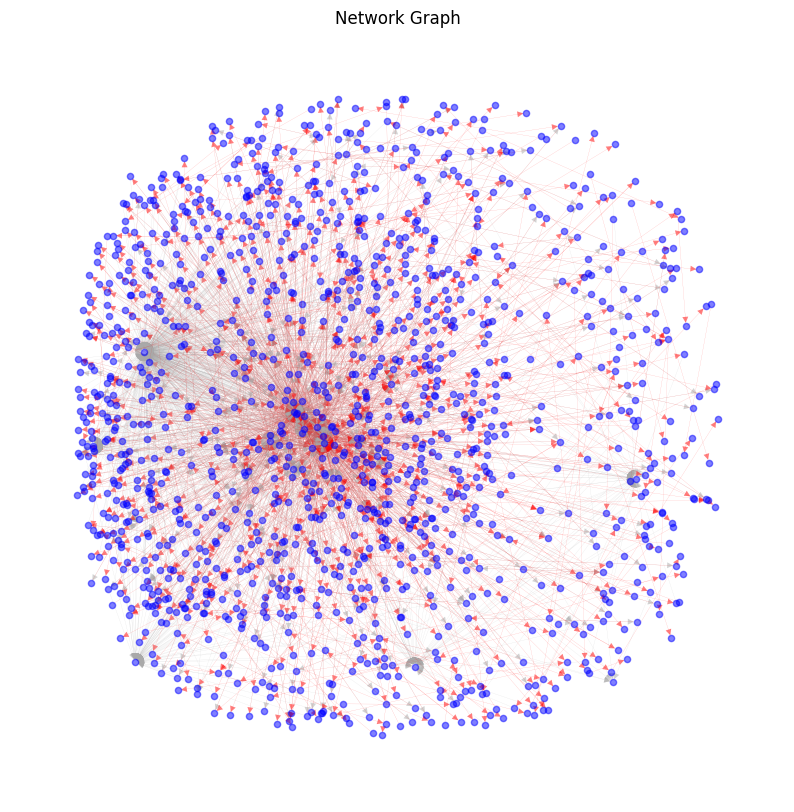

In [32]:
# Assuming the combined DataFrame is named 'combined_df'
G = nx.from_pandas_edgelist(df, source='from', target='to', edge_attr='tokenType', create_using=nx.DiGraph())

# Create a color map for the edges
colors = ['red' if G[u][v]['tokenType']==721 else 'darkgrey' for u, v in G.edges()]

plt.figure(figsize=(10, 10))

# Create a layout for the nodes
layout = nx.spring_layout(G, k=0.15, iterations=20)

# Draw the network
nx.draw_networkx(G, pos=layout, with_labels=False, node_size=20, node_color='blue', edge_color=colors, width=0.1, alpha=0.5)

plt.title('Network Graph')
plt.axis('off')
plt.show()

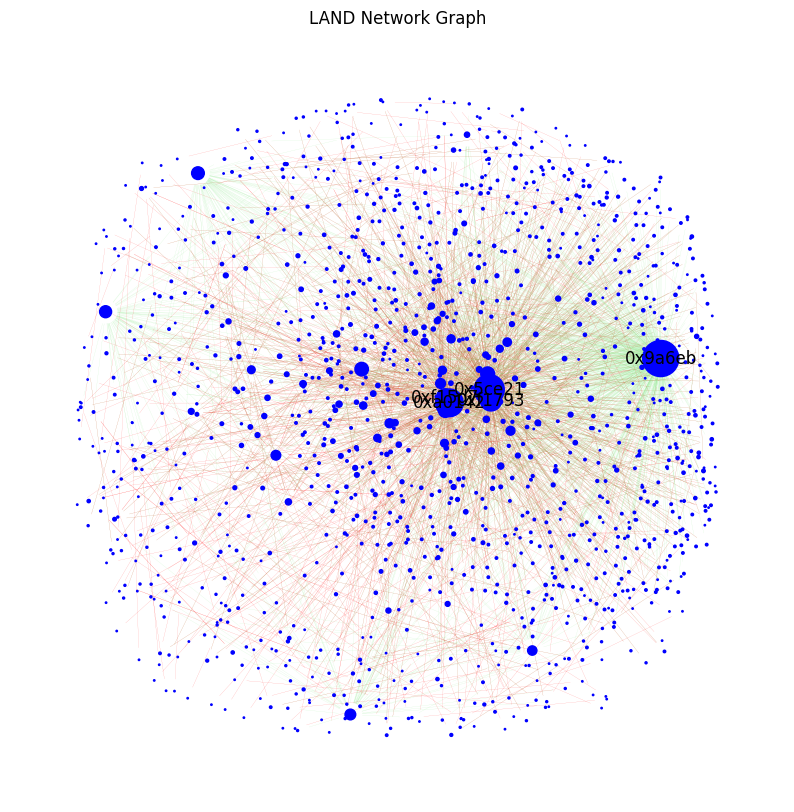

In [11]:
# Assuming the combined DataFrame is named 'combined_df'
G = nx.from_pandas_edgelist(df, source='from', target='to', edge_attr='tokenType', create_using=nx.DiGraph())

# Create a color map for the edges
colors = ['red' if G[u][v]['tokenType']==721 else 'lightgreen' for u, v in G.edges()]

plt.figure(figsize=(10, 10))

# Create a layout for the nodes
layout = nx.spring_layout(G, k=0.15, iterations=20)


# Calculate degrees of each node and create a list of node sizes
degrees = [G.degree(n) for n in G.nodes()]
node_sizes = [d * 1.1 for d in degrees]  # Adjust size multiplier as needed

# Draw the edges first, with custom colors and width
nx.draw_networkx_edges(G, pos=layout, edge_color=colors, width=0.1, alpha=0.6, arrowstyle="-")

# Then draw the nodes on top
nx.draw_networkx_nodes(G, pos=layout, node_size=node_sizes, node_color='blue')


# Labels
degree_weight = dict(G.degree(weight='weight'))
sorted_nodes = sorted(degree_weight.items(), key=lambda x: x[1], reverse=True)
top_nodes = [n for n, d in sorted_nodes[:5]]
labels = {node: node[:7] for node in top_nodes}
nx.draw_networkx_labels(G, layout, labels=labels, font_color='black')


plt.title('LAND Network Graph')
plt.axis('off')
plt.savefig("../figures/token_network.png", dpi=500, transparent=False)
plt.show()

In [45]:
labels

{'0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce': '0x9a6eb',
 '0x5ce213893956bbf4249a7f8a079331280065eec6': '0x5ce21',
 '0xa01424b7540adbb792375dcf97b733a5d68ad347': '0xa0142',
 '0xf179344bbec75ad4522bd6b2c780b2e13b3469a2': '0xf1793',
 '0xf15d7066b78a4e969deefa1e4ca945212ddd3171': '0xf15d7'}

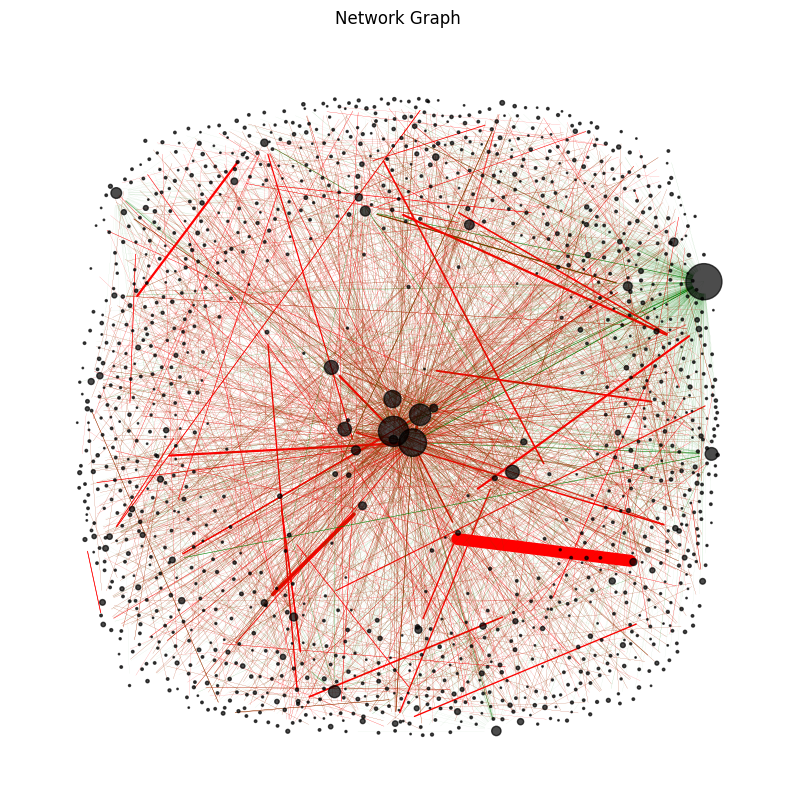

In [16]:
# Group the data by 'from','to','tokenType' and calculate the size of each group
grouped_df = df.groupby(['from','to','tokenType']).size().reset_index(name='weight')

# Create the graph using 'weight' as the edge attribute
G = nx.from_pandas_edgelist(grouped_df, source='from', target='to', edge_attr=True, create_using=nx.DiGraph())

plt.figure(figsize=(10, 10))


# Create a color map for the edges
colors = ['red' if G[u][v]['tokenType']==721 else 'green' for u, v in G.edges()]

# Create a list of edge widths based on the 'weight' attribute (you may need to adjust the scaling factor)
widths = [G[u][v]['weight'] / 50.0 for u, v in G.edges()]

# Create a layout for the nodes
layout = nx.spring_layout(G, k=0.5, iterations=10)

# Calculate degrees of each node and create a list of node sizes
degrees = [G.degree(n) for n in G.nodes()]
node_sizes = [d * 1.1 for d in degrees]

# Draw the edges with colors and widths based on the edge attributes
nx.draw_networkx_edges(G, pos=layout, edge_color=colors, width=widths, arrowstyle="-")

# Draw the nodes
nx.draw_networkx_nodes(G, pos=layout, node_size=node_sizes, node_color='black', alpha=0.7)

plt.title('Network Graph')
plt.axis('off')
plt.show()